
# Lab 6: Object Localization with Fast R-CNN for Mobile Phone Detection

**Objective**
- the implementation of an object localization model using Fast R-CNN in PyTorch for detecting mobile phones. It involves:
 -  Understanding object localization vs. classification.
 -  Utilizing Fast R-CNN for bounding box predictions and class probabilities.
 - Applying evaluation metrics like mAP (mean Average Precision) and IoU (Intersection over Union).

**Dataset Information**

- Dataset: Mobile Phone Detection Dataset -  https://universe.roboflow.com/l-u7ala/productrecog-94bfc
- Format: COCO JSON annotations
- Classes: 1 (mobile-phone)

Splits:

- Training: 481 images (81%)
- Validation: 67 images (11%)
- Test: 49 images (8%)


Image Format: JPG

Annotation Format: COCO JSON with bounding boxes

# Object Localization vs. Classification

**Classification:** Predicts only the class label of an object

**Localization:** Predicts both class label and object location (bounding box)

### Output Format

- **Classification:** Class probabilities
- **Localization:** Class probabilities + Bounding box coordinates (x, y, width, height)


# Mobile Phone Detection using Fast R-CNN

## 1. Environment Setup
### Data Preparation
- Install necessary libraries:
    ```bash
    pip install torch torchvision pycocotools albumentations matplotlib numpy pandas
    ```
- Mount Google Drive to access datasets and annotations.

---

## 2. Data Loading and Preparation
### Custom Dataset Class:
- Implements PyTorch's `Dataset` for loading COCO annotations.
- Prepares image tensors and bounding box targets ([x1, y1, x2, y2]).
- Supports transformations (optional).

### Key Methods:
- `__getitem__`: Loads images and bounding box annotations.
- `__len__`: Returns the size of the dataset.

---

## 3. Model Setup
### Fast R-CNN Architecture:
- **Base Model**: `fasterrcnn_resnet50_fpn_v2` (pre-trained).
- **Custom Head**:
  - Replaces the pre-trained classification layer.
  - Predicts bounding boxes and classes (background + mobile phones).

### Key Function:
- `get_model(num_classes)`: Configures the model with a new head for custom classes.

---

## 4. Training Pipeline
### Tasks:
1. **Set Device**:
   - Use GPU if available:
     ```python
     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     ```
2. **Load Datasets**:
   - Train and validation datasets.
   - Use `DataLoader` for batching and shuffling.

3. **Optimizer and Scheduler**:
   - **Optimizer**: SGD with a learning rate of 0.001.
   - **Scheduler**: `StepLR` to decay learning rate.

4. **Training Loop**:
   - Perform forward and backward passes.
   - Update weights using calculated loss.

---

## 5. Evaluation
### Metrics:
- **IoU (Intersection over Union)**: Measures overlap between predicted and ground truth bounding boxes.
- **mAP (Mean Average Precision)**: Evaluates detection performance across classes.

---

## 6. Inference and Visualization
### Tasks:
1. **Inference Function**:
   - Loads test images.
   - Uses the trained model to predict bounding boxes and confidence scores.
2. **Visualization Function**:
   - Draws bounding boxes on images with confidence scores.

### Key Functionality:
- `detect_phones`: Runs inference.
- `visualize_detection`: Plots predictions.

---
run_inference('model_checkpoint.pth', 'test_image.jpg')


## 1. Environment Setup


In [3]:
# !pip install torch torchvision
# !pip install pycocotools
# !pip install albumentations
# !pip install matplotlib numpy pandas

In [4]:
# !pip install pycocotools
# !pip install albumentations

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Import necessary libraries
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader

In [8]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Data Loading and Preparation


In [38]:
class MobilePhoneDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Load COCO format annotations
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

        # Filter for mobile phone class
        cat_ids = self.coco.getCatIds(catNms=['mobile-phone'])
        self.category_id_to_label = {cat_id: 1 for cat_id in cat_ids}  # Map to label 1

    def __getitem__(self, index):
        # Load image
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(image_path).convert('RGB')

        # Convert PIL Image to tensor
        image = F.to_tensor(image)

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []

        for ann in anns:
            boxes.append(ann['bbox'])  # [x, y, width, height]
            labels.append(1)  # 1 for mobile phone

        # Convert boxes to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Convert from [x, y, w, h] to [x1, y1, x2, y2]
        if len(boxes) > 0:
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # Prepare target
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.tensor([img_id])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)

## 3. Model Setup


In [36]:
def get_model(num_classes=2):  # 2 classes: background + mobile phone
    # Load pre-trained model
    model = fasterrcnn_resnet50_fpn_v2(pretrained=True)

    # Get number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

## 4. Training Pipeline


In [39]:
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")


# Dataset paths
train_root = '/content/drive/MyDrive/phone dataset/train'
train_annot = '/content/drive/MyDrive/phone dataset/train/_annotations.coco.json'
val_root = '/content/drive/MyDrive/phone dataset/valid'
val_annot = '/content/drive/MyDrive/phone dataset/valid/_annotations.coco.json'

# Create datasets
train_dataset = MobilePhoneDataset(train_root, train_annot)
val_dataset = MobilePhoneDataset(val_root, val_annot)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

# Create data loaders with smaller batch size for memory efficiency
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=2
)

# Initialize model
model = get_model(num_classes=2)  # background + mobile phone
model.to(device)

# Optimizer with lower learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop with try-except for debugging
num_epochs = 10
print("Starting training...")

try:
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        total_loss = 0
        num_batches = len(train_loader)

        for i, (images, targets) in enumerate(train_loader):
            # Move images and targets to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

            if i % 10 == 0:  # Print every 10 batches
                print(f"  Batch {i+1}/{num_batches}, Loss: {losses.item():.4f}")

        # Step the scheduler
        lr_scheduler.step()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'mobile_detector_epoch_{epoch+1}.pth')

except Exception as e:
    print(f"Error during training: {str(e)}")
    import traceback
    traceback.print_exc()


Using device: cuda
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training images: 481
Number of validation images: 67
Starting training...
Epoch 1/10
  Batch 1/241, Loss: 1.1296
  Batch 11/241, Loss: 0.7986
  Batch 21/241, Loss: 0.2058
  Batch 31/241, Loss: 0.7237
  Batch 41/241, Loss: 0.1686
  Batch 51/241, Loss: 0.2139
  Batch 61/241, Loss: 0.1602
  Batch 71/241, Loss: 0.1682
  Batch 81/241, Loss: 0.3659
  Batch 91/241, Loss: 0.1043
  Batch 101/241, Loss: 0.0908
  Batch 111/241, Loss: 0.2563
  Batch 121/241, Loss: 0.1163
  Batch 131/241, Loss: 0.1343
  Batch 141/241, Loss: 0.0981
  Batch 151/241, Loss: 0.1820
  Batch 161/241, Loss: 0.1195
  Batch 171/241, Loss: 0.1268
  Batch 181/241, Loss: 0.0790
  Batch 191/241, Loss: 0.1007
  Batch 201/241, Loss: 0.0813
  Batch 211/241, Loss: 0.1764
  Batch 221/241, Loss: 0.0943
  Batch 231/241, Loss: 0.0886
  Batch 241

## 5. Evaluation


In [47]:
from collections import defaultdict
from torchvision.ops import box_iou
from tqdm import tqdm



In [48]:
def get_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def evaluate_single_image(pred_boxes, pred_scores, target_boxes, iou_threshold=0.5):
    """
    Evaluate predictions for a single image
    """
    if len(pred_boxes) == 0:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    if len(target_boxes) == 0:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    # Calculate IoU between predicted and ground truth boxes
    iou_matrix = box_iou(pred_boxes, target_boxes)

    # Get maximum IoU for each predicted box
    max_ious, _ = iou_matrix.max(dim=1)

    # True positives: predicted boxes with IoU > threshold
    true_positives = (max_ious >= iou_threshold).sum().item()

    # Calculate metrics
    precision = true_positives / len(pred_boxes)
    recall = true_positives / len(target_boxes)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def evaluate_model(model, data_loader, device, confidence_threshold=0.5):
    """
    Evaluate model performance on the validation set
    """
    model.eval()
    total_metrics = defaultdict(float)
    all_predictions = []
    all_targets = []
    num_images = 0

    print("\nEvaluating model...")
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            # Move images to device
            images = [image.to(device) for image in images]
            predictions = model(images)

            # Process each image in the batch
            for pred, target in zip(predictions, targets):
                # Filter predictions by confidence
                mask = pred['scores'] >= confidence_threshold
                pred_boxes = pred['boxes'][mask].cpu()
                pred_scores = pred['scores'][mask].cpu()
                target_boxes = target['boxes'].cpu()

                # Store predictions and targets for mAP calculation
                all_predictions.append((pred_boxes, pred_scores))
                all_targets.append(target_boxes)

                # Calculate metrics for this image
                metrics = evaluate_single_image(pred_boxes, pred_scores, target_boxes)
                for k, v in metrics.items():
                    total_metrics[k] += v
                num_images += 1

    # Calculate average metrics
    avg_metrics = {k: v / num_images for k, v in total_metrics.items()}

    # Calculate mAP
    mAP = calculate_map(all_predictions, all_targets)
    avg_metrics['mAP'] = mAP

    return avg_metrics

def calculate_map(all_predictions, all_targets, iou_thresholds=None):
    """
    Calculate mean Average Precision
    """
    if iou_thresholds is None:
        iou_thresholds = np.linspace(0.5, 0.95, 10)

    aps = []
    for iou_threshold in iou_thresholds:
        ap = calculate_ap_at_threshold(all_predictions, all_targets, iou_threshold)
        aps.append(ap)

    mAP = np.mean(aps)
    return mAP

def calculate_ap_at_threshold(all_predictions, all_targets, iou_threshold):
    """
    Calculate Average Precision at a specific IoU threshold
    """
    all_detections = []
    num_positives = sum(len(target_boxes) for target_boxes in all_targets)

    # Collect all detections
    for (pred_boxes, pred_scores), target_boxes in zip(all_predictions, all_targets):
        if len(pred_boxes) == 0:
            continue

        iou_matrix = box_iou(pred_boxes, target_boxes)
        max_ious, _ = iou_matrix.max(dim=1)

        for score, iou in zip(pred_scores, max_ious):
            all_detections.append({
                'score': score.item(),
                'tp': iou >= iou_threshold
            })

    # Sort detections by confidence
    all_detections.sort(key=lambda x: x['score'], reverse=True)

    # Calculate precision and recall
    precisions = []
    recalls = []
    num_correct = 0
    for i, detection in enumerate(all_detections):
        if detection['tp']:
            num_correct += 1
        precision = num_correct / (i + 1)
        recall = num_correct / num_positives
        precisions.append(precision)
        recalls.append(recall)

    if not precisions:
        return 0.0

    # Calculate AP using all points
    ap = np.trapz(precisions, recalls) if recalls else 0.0
    return ap

def visualize_predictions(model, dataset, device, num_images=5, confidence_threshold=0.5):
    """
    Visualize model predictions on sample images
    """
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    with torch.no_grad():
        for i in range(num_images):
            # Get random image
            img, target = dataset[np.random.randint(len(dataset))]

            # Get prediction
            prediction = model([img.to(device)])
            pred = prediction[0]

            # Filter predictions by confidence
            mask = pred['scores'] >= confidence_threshold
            boxes = pred['boxes'][mask].cpu()
            scores = pred['scores'][mask].cpu()

            # Convert tensor image to numpy for plotting
            img = img.cpu().permute(1, 2, 0).numpy()

            # Plot image
            ax = axes[i]
            ax.imshow(img)

            # Draw predicted boxes
            for box, score in zip(boxes, scores):
                x1, y1, x2, y2 = box.tolist()
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                  fill=False, color='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(x1, y1-5, f'{score:.2f}',
                       bbox=dict(facecolor='white', alpha=0.7))

            ax.axis('off')

    plt.tight_layout()
    plt.show()

def run_evaluation(model_path, val_loader, device):
    """
    Run complete model evaluation
    """
    # Load model
    model = get_model(num_classes=2)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # Evaluate model
    metrics = evaluate_model(model, val_loader, device)

    # Print results
    print("\n=== Evaluation Results ===")
    print(f"Mean Average Precision (mAP): {metrics['mAP']:.4f}")
    print(f"Average Precision: {metrics['precision']:.4f}")
    print(f"Average Recall: {metrics['recall']:.4f}")
    print(f"Average F1 Score: {metrics['f1']:.4f}")

    # Visualize some predictions
    print("\nGenerating visualization of predictions...")
    visualize_predictions(model, val_loader.dataset, device)

    return metrics

<ipython-input-48-d6730a283150>:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Evaluating model...


100%|██████████| 67/67 [00:12<00:00,  5.23it/s]



=== Evaluation Results ===
Mean Average Precision (mAP): 0.6545
Average Precision: 0.8893
Average Recall: 0.9739
Average F1 Score: 0.9143

Generating visualization of predictions...


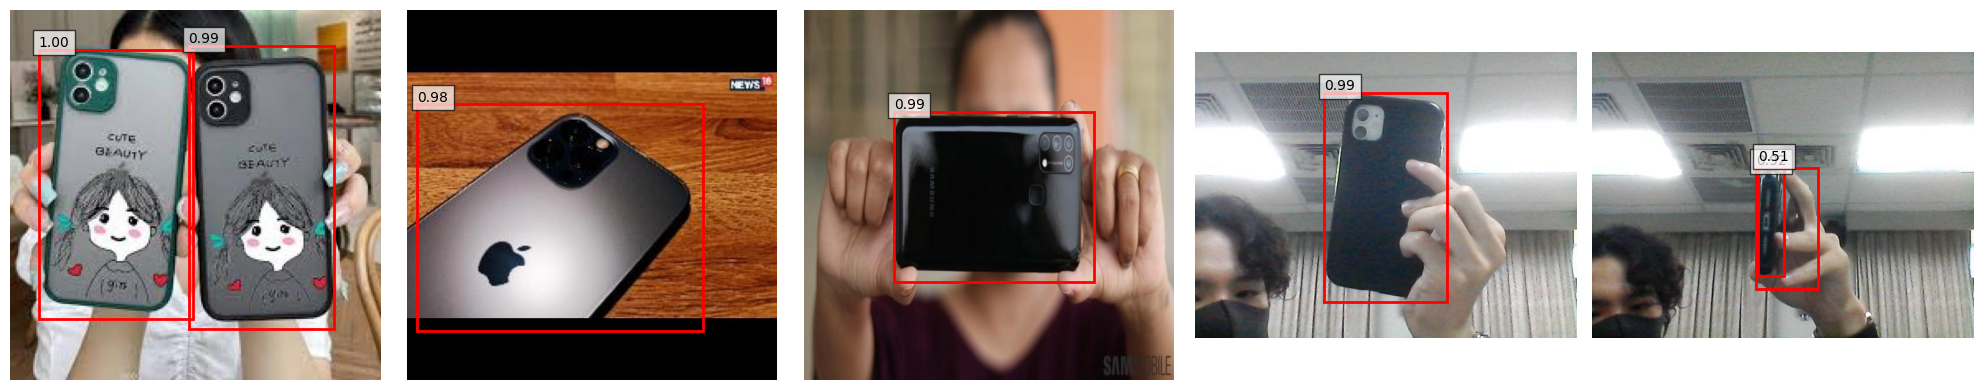

In [49]:
results = run_evaluation(
    model_path='/content/mobile_detector_epoch_10.pth',
    val_loader=val_loader,
    device=device
)

## 6. Inference and Visualization


In [40]:
# Inference function
def detect_phones(model, image_path, device, conf_threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)

    # Filter predictions by confidence
    boxes = prediction[0]['boxes'][prediction[0]['scores'] > conf_threshold]
    scores = prediction[0]['scores'][prediction[0]['scores'] > conf_threshold]

    return image, boxes.cpu(), scores.cpu()

# Visualization function
def visualize_detection(image, boxes, scores):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'{score:.2f}', bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.show()

# Function to run inference on a test image
def run_inference(model_path, image_path):
    # Load model
    model = get_model(num_classes=2)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Run detection
    image, boxes, scores = detect_phones(model, image_path, device)
    visualize_detection(image, boxes, scores)

    return boxes, scores

<ipython-input-40-90fb1b5ff341>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


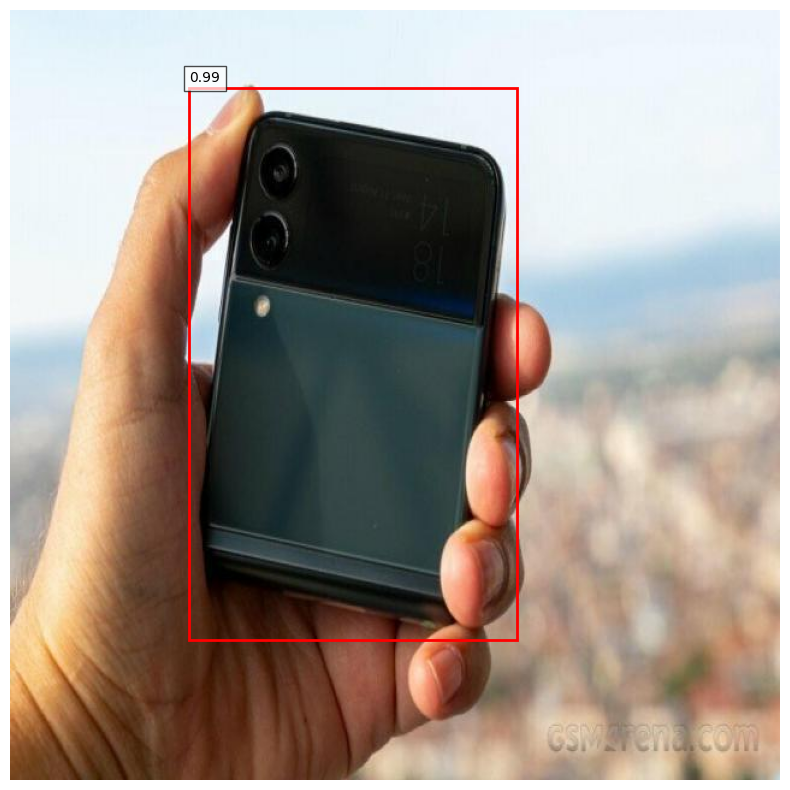

(tensor([[148.6618,  64.4105, 420.5332, 522.9233]]), tensor([0.9915]))

In [51]:
run_inference('/content/mobile_detector_epoch_10.pth', '/content/drive/MyDrive/phone dataset/test/59381278d7b7ab85dfaa44e35c67a64a_jpg.rf.5b477cadcdafcdfaa3429691beceab11.jpg')
